In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

import matplotlib.pyplot as plt
import imageio
from PIL import Image
from datetime import datetime
from tqdm import tqdm
from p_tqdm import p_imap

# from perlin_noise import PerlinNoise
import pyfastnoisesimd as fns

from IPython.display import display, clear_output
import time

# Define classes

In [2]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1)
#         nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            stdv = 1. / np.sqrt(m.weight.size(1))
            m.bias.data.uniform_(-stdv, stdv)
#             m.bias.data.fill_(0)
#     classname = m.__class__.__name__
#     if classname.find('Linear') != -1:
#         m.weight.data.normal_(0.0, 1.0)
#         if m.bias is not None:
#             m.bias.data.fill_(0)

def p_work(sampler, xv, yv, zv):
    return sampler.generate_ndNoise(noiseObj, xv, yv, zv)

class CPPN_block(nn.Module):
    """
    A linear layer 
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.lin = nn.Linear(in_channels, out_channels, bias=True)
#         self.in_l2 = nn.Linear(out_channels, out_channels)

#         self.conv1d = nn.Conv1d(out_channels, out_channels, 5, padding=5//2)
#         self.conv2d = nn.Conv2d(out_channels, out_channels, 5, padding=5//2)

#         self.bnl = nn.BatchNorm1d(out_channels)
#         self.bnl = nn.BatchNorm2d(out_channels)

        self.afunc = nn.Tanh()
        

    def forward(self, x):
        x = self.lin(x)   
#         x = self.in_l2(x)

#         x = self.conv2d(x.reshape(-1, x.shape[2], yres, xres)).reshape(-1, xres*yres, x.shape[2])
#         x = self.bnl(x.reshape(-1, x.shape[2], yres, xres)).reshape(-1, yres*xres, x.shape[2])

#         x = self.conv1d(x.permute(0, 2, 1))        
#         x = self.bnl(x.permute(0, 2, 1)).permute(0, 2, 1)

        x = self.afunc(x)
        
        return x
    

class Rule(nn.Module):
    def __init__(self, dim_in, dim_z, dim_c, net_size):
        super().__init__()
        
        self.in_l = [nn.Linear(1, net_size[0], bias=False).cuda() for i in range(dim_in - 1)]
        self.in_l.append(nn.Linear(dim_z, net_size[0], bias=False).cuda())
        self.in_l = nn.ModuleList(self.in_l)
        
        self.seq = []
#         self.bnls = []
        for i in range(len(net_size) - 1):
#             self.seq.append((nn.Linear(net_size[i], net_size[i + 1])))
#             if (i + 1) % 3 == 0:
#                 self.bnls.append(nn.BatchNorm1d(net_size[i]))
#             self.seq.append(nn.Tanh())
            self.seq.append(CPPN_block(in_channels=net_size[i], out_channels=net_size[i+1]))
            
#             self.seq.append(nn.Conv2d(net_size[i], net_size[i + 1], 3, padding=1, padding_mode='reflect'))
#             self.seq.append(nn.ReLU())
        
        self.seq.append(nn.Linear(net_size[-1], dim_c, bias=False))
        self.seq.append(nn.Sigmoid())
        
        self.seq = nn.ModuleList(self.seq)
#         self.bnls = nn.ModuleList(self.bnls)

            
class CPPN(nn.Module):
    def __init__(self, net_size=[32, 32, 32], dim_z=16, dim_c=3, scale=5, res=512):
        super().__init__()
        
        self.dim_c = dim_c
        self.init_grid(scale, res)  # init self.coords
        
        self.dim_in = len(self.coords)
#         self.ls_coords = [nn.Linear(1, net_size[0], bias=False).cuda() for i in range(self.dim_in - 1)]
#         self.ls_coords.append(nn.Linear(dim_z, net_size[0], bias=False).cuda())  # the layer for the latent-vector z
        
#         modules = []
#         modules.append(nn.Tanh())
#         for i in range(len(net_size) - 1):
#             modules.append(nn.Linear(net_size[i], net_size[i + 1]))
#             modules.append(nn.Tanh())
            
#         modules.append(nn.Linear(net_size[-1], dim_c))
#         modules.append(nn.Sigmoid())

        self.rule = Rule(self.dim_in, dim_z, self.dim_c, net_size)
#         self.ls_coords = self.rule.in
#         self.seq = nn.Sequential(*self.rule.seq)

#         self.seq = nn.Sequential(*modules)
#         self.modules = nn.ModuleList((self.ls_coords + modules))
        
        self.apply(weights_init)
        
    def _coordinates(self, scale, xres, yres, z, flatten=True, batch_size=1, num_nulls=3):
        
        # check if z has the same batch dim as batch_size
        
        z = z.unsqueeze(1)
        
        # generate X, Y, R coordinate grid
        aspect_ratio = xres / yres
        xv = np.linspace(-scale, scale, xres) * aspect_ratio
        yv = np.linspace(-scale, scale, yres)
        X, Y = np.meshgrid(xv, yv)
        R = np.sqrt(X**2 + Y**2)  
        
        # placeholder matrices that can be replaced with images or what-have-you....
        null = 0 * R
        nulls = [null for i in range(num_nulls)]
        
        spacecoords = [X, Y, R] + nulls
        
        # only kept unflattened for hires images 
        if flatten:
            spacecoords = [c.reshape(1, -1, 1) for c in spacecoords]
#             X, Y, R, null = X.reshape(1, -1, 1), Y.reshape(1, -1, 1), R.reshape(1, -1, 1), null.reshape(1, -1, 1) # shape=(batch_size, *, in_features)
        
        # tile for batch size
        spacecoords = [np.tile(c, (batch_size, 1, 1)) for c in spacecoords]
#         X, Y, R, null = np.tile(X, (batch_size, 1, 1)), np.tile(Y, (batch_size, 1, 1)), np.tile(R, (batch_size, 1, 1)), np.tile(null, (batch_size, 1, 1))
        
        spacecoords = [torch.cuda.FloatTensor(c) for c in spacecoords]

        return spacecoords + [z]
    
    def init_grid(self, scale, res, z=None, num_nulls=3):
        if z is None:
            z = torch.zeros(dim_z)
        self.coords = [coord for coord in self._coordinates(scale, res, res, z, num_nulls)]
    
    def reinit(self, empty_cache=False):
        
        if empty_cache:
            torch.cuda.empty_cache()
            
        self.apply(weights_init)
    
    def forward(self, coords, xres, yres):
        
        if coords is None:
            coords = self.coords
            
#         U = [self.rule.in_l[i](torch.cuda.FloatTensor(coord)) for i, coord in enumerate(coords)]
        U = [self.rule.in_l[i](coord) for i, coord in enumerate(coords)]

        U = sum(U)
        U = torch.tanh(U)
        
        # linear layers
        out = nn.Sequential(*self.rule.seq)(U)


#         out = self.rule.seq[0](U)
#         seq = self.rule.seq[1:]
#         bnl_counter = 0
#         layer_counter = 0
#         for i in range(0, len(seq)): 
#             out = self.rule.seq[i](out)
#             if type(self.rule.seq[i]) == nn.Linear:
#                 layer_counter += 1
#             print(f'layer_counter: {layer_counter}')
#             if (layer_counter + 1) % 3 == 0:
#                 print(f'i: {i}')
#                 print(out.shape)
#                 out = out.permute(0, 2, 1)
#                 print(out.shape)
#                 out = self.rule.bnls[bnl_counter](out)
#                 out = out.permute(0, 2, 1)
#                 bnl_counter += 1
                


        # if using convs
#         U = U.permute(0, 2, 1).reshape(U.shape[0], -1, yres, xres)
#         out = nn.Sequential(*self.rule.seq[:-2])(U)
#         out = out.permute(0, 2, 3, 1).reshape(out.shape[0], -1, out.shape[1])
#         out = nn.Sequential(*self.rule.seq[-2:])(out)
        
        return out
    
class Sampler():
    def __init__(self, res=512, scale=5):
        self.res = res
        self.scale = scale

    
    def generate_img(self, cppn, z, scale=None, xres=None, yres=None, coords=None):
        
        with torch.no_grad():
            if scale is None:
                scale = self.scale
            if xres is None or yres is None:
                xres = self.res
                yres = self.res
            if coords is None:
                coords = cppn._coordinates(scale, res, res, z)

            out = cppn.forward(coords, xres, yres).cpu().numpy()

        return out.reshape(yres, xres, -1)
    
    def imshow(self, x):
        
        img = x
            
        dim_c = img.shape[2]
    
        fig, ax = plt.subplots(figsize=(9, 16))

        if dim_c == 1:
            img = img[:, :, 0]
            ax.imshow(img, cmap='Greys')
        else:        
            ax.imshow(img)
        ax.set_axis_off()
        plt.show()
    
    def generate_hires(self, cppn, z, scale=None, x_dim=256, y_dim=256, x_reps=16, y_reps=9, coords=None):
        
        if scale is None:
            scale = self.scale

        x_dim_big = x_dim*x_reps
        y_dim_big = y_dim*y_reps
        
        with torch.no_grad():
            if coords is None:
                coords = cppn._coordinates(scale, x_dim_big, y_dim_big, z, flatten=False)
                
            # just expect all input coords to be non-flattened
#             else:
#                 coords = [coord.reshape(-1, y_dim_big, x_dim_big) for coord in coords]

            z = coords[-1]
            coords = coords[:-1]

            out = np.zeros((y_dim_big, x_dim_big, cppn.dim_c))
            for ix in tqdm(range(x_reps)):
                x_start = ix * x_dim
                x_end = x_start + x_dim

                for iy in range(y_reps):
                    y_start = iy * y_dim
                    y_end = y_start + y_dim

                    coords_small = [coord[:, y_start:y_end, x_start:x_end].reshape(1, -1, 1) for coord in coords]
                    coords_small.append(z)
                    
                    img_section = cppn.forward(coords_small, x_dim, y_dim).reshape(y_dim, x_dim, cppn.dim_c)

                    out[y_start:y_end, x_start:x_end, :] = img_section.cpu().numpy()
                
        return out
    
    
    def initNoise(self, frequency=0.02, octaves=6, lacunarity=2, gain=0.45,
              seed=0, numWorkers=11):
        # initialize noise object, at the moment it is set to be simply Perlin noise
        self.noise = fns.Noise(seed=seed, numWorkers=numWorkers)

        self.noise.noiseType = fns.NoiseType.PerlinFractal
        self.noise.fractal.fractalType = fns.FractalType.FBM
        self.noise.frequency = frequency
        self.noise.fractal.octaves = octaves
        self.noise.fractal.lacunarity = lacunarity
        self.noise.fractal.gain = gain
        self.noise.perturb.perturbType = fns.PerturbType.NoPerturb


    def generate_ndNoise(self, xv, yv, zv):
        # calculates n dimensional noise texture for the coordinates generated by the xv, yv, zv vectors

        # generate flattened coordinate vectors (size = len(xv)*len(yv)*len(zv))
        in_coords = self.generate_noiseCoords(xv, yv, zv)
        N = np.shape(in_coords)[1]

        coords = fns.empty_coords(N)
        # <Set the coordinate values, it is a (3, numCoords) array
        coords[0, :] = in_coords[0, :]
        coords[1, :] = in_coords[1, :]
        coords[2, :] = in_coords[2, :]

        return self.noise.genFromCoords(coords).reshape(len(xv), len(yv), len(zv))

    def generate_noiseCoords(self, xv, yv, zv):
        # generates a vector of 3-D coordinates from the vectors xv, yv, zv which specify the domains in each
        # dimension
        X, Y, Z = np.meshgrid(xv, yv, zv)
        X = X.flatten()
        Y = Y.flatten()
        Z = Z.flatten()

        return np.array([(X[i], Y[i], Z[i]) for i in range(len(X))]).transpose()
    
    def generate_ndNoise_hires(self, xv, yv, zv, res=512, x_reps=8, y_reps=8):
        # calculates n dimensional noise texture for the coordinates generated by the xv, yv, zv vectors
       
        out  = np.zeros((len(xv), len(yv)))
        params=[]
        for ix in range(x_reps):
            x_start = ix * res
            x_end = x_start + res
            
            xv_small = xv[x_start:x_end]
            
            for iy in range(y_reps):
                y_start = iy * res
                y_end = y_start + res
                
                yv_small = yv[y_start:y_end]
                
                params.append( (self, xv_small, yv_small, zv) )
                
#                 in_coords = self.generate_noiseCoords(xv_small, yv_small, zv)
                
#                 N = np.shape(in_coords)[1]

#                 coords = fns.empty_coords(N)
        
#                 # <Set the coordinate values, it is a (3, numCoords) array
#                 coords[0, :] = in_coords[0, :]
#                 coords[1, :] = in_coords[1, :]
#                 coords[2, :] = in_coords[2, :]
                
#                 params.append(coords)
                
#                 img_section = noiseObj.genFromCoords(coords).reshape(res, res, len(zv))[:, :, 0]
                
#                 out[y_start:y_end, x_start:x_end] = img_section

        img_sections = list(p_imap(p_work, params))
        
        counter = 0
        for ix in range(x_reps):
            x_start = ix * res
            x_end = x_start + res
            
            for iy in range(y_reps):
                y_start = iy * res
                y_end = y_start + res
                
                out[y_start:y_end, x_start:x_end] = img_sections[counter]
                counter +=1

        return out
    
###################### TRAINING FUNCTION ######################

def multiscale_targets(target, coords, res, batch_size, big_factor):
    '''
    Generates a set of targets and their associated coordinate grid randomly across the batch dimension.
    
    big_factor: value between [0., 1.] that controls how large the crops of the target image tend to be. 
                - a value of 1 means the images will not be cropped
                - a value of 0 means the iamges will be randomly cropped across all possible window sizes
    '''
    shape = np.array(target).shape
    target_max = np.array(target).max()
    #crop size control (kind of fucky)
    buffer = int((shape[0] - res[0] - 1)*big_factor) , int((shape[1] - res[1] - 1)*big_factor)
    TARGETS = []
    S = []
    T = []
    for i in range(batch_size):
        
        # random top left index for bounding box
        tl_p = ( np.random.randint(0, shape[0] - res[0] - buffer[0]),
                 np.random.randint(0, shape[1] - res[1] - buffer[1])
               )
        # random bottom right index w.r.t. model resolution and target resolution
        delta_x_max = (shape[1] - tl_p[1])
        delta_y_max = delta_x_max * shape[0]/shape[1] # constraint due to aspect ratio / other dim
        max_y = np.min([tl_p[0] + delta_y_max + 1, shape[0]]) # constraint due to image boundries
        
        # control size of crops with one parameter
        # (this is kind of fucky, should fix, look at 2d hist of x,y)
        buffery2 = int((max_y - tl_p[0] - res[0] - 1)*(big_factor))  
        min_y = tl_p[0] + res[0] + buffery2
        
#         print(f'(x1, y1): ({tl_p[0]:.2f}. {tl_p[1]:.2f})')
        if int(min_y) >= int(max_y):
            print(f'y2: [{min_y:.2f} : {max_y:.2f}]')
            print(f'x1: {tl_p[1]}, delta_x_max: {delta_x_max:.2f}')
            print(f'y1: {tl_p[0]}. delta_y_max: {delta_y_max:.2f}')
        # bottom right coordinates
        y2 = np.random.randint(min_y, max_y)
        x2 = int( tl_p[1] + (y2 - tl_p[0] + 1) * ((shape[1] - 1)/shape[0]) ) 

        br_p = (y2 ,x2)
        
        # calculate scale/translation factors to be used to shift cppn input coordinates
        s = ( (y2 - tl_p[0]) / (shape[0] - 1), (x2 - tl_p[1]) / (shape[1] - 1) )  # L*/L
        t = ( 2*(tl_p[0]/(shape[0] - 1) - 0.5) , 2*(tl_p[1]/(shape[1] - 1) - 0.5) )  # maps point_topleft (0, shape) -> (-1, 1)
        
        points = (tl_p[1], tl_p[0], br_p[1], br_p[0]) # (x1, y1, x2, y2) top left and bottom right points
#         print(points)
        
        target_crop = deepcopy(target)
        target_crop = target_crop.crop(points)
        target_crop = target_crop.resize((res[1], res[0]), Image.ANTIALIAS)
        target_crop = np.array(target_crop)
        
        S.append(s)
        T.append(t)
        TARGETS.append(target_crop/target_max)
        
    return np.array(TARGETS), np.array(S), np.array(T)

def multiscale_targets_apply(x, img, XRES, YRES, BATCH_SIZE, big_factor, keep_full=True, num_full=1):  
    TARGET, S, T = multiscale_targets(img, x, (YRES, XRES), BATCH_SIZE, big_factor)
    
    # ensures at least one batch dim is the full res picture
    if keep_full:
        target_orig = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))
        target_orig = target_orig/target_orig.max()
        target_orig = np.tile(target_orig, (num_full, 1, 1, 1))
        
        TARGET[:num_full] = target_orig
        
        S[:num_full, :] = np.tile(np.array([1, 1]), (num_full, 1))
        T[:num_full, :] = np.tile(np.array([-1, -1]), (num_full, 1))
        

    min_x_old = x[0].min(1)[:, 0]
    min_x_scaled = min_x_old*S[:, 1]
    translation_x = T[:, 1]*np.abs(min_x_old) - min_x_scaled
    x[0] = x[0] * S[:, 1][:, None, None] + translation_x[:, None, None]

    min_y_old = x[1].min(1)[:, 0]
    min_y_scaled = min_y_old*S[:, 0]
    translation_y = T[:, 0]*np.abs(min_y_old) - min_y_scaled
    x[1] = x[1] * S[:, 0][:, None, None] + translation_y[:, None, None]

    x[2] = np.sqrt(x[0]**2 +  x[1]**2)
    TARGET = torch.cuda.FloatTensor(TARGET[:, :, :, :3]).reshape(BATCH_SIZE, -1, 3)
    
    return x, TARGET

In [57]:
# net_size = [1024, 32, 256, 16, 128, 6]
# net_size = [512, 32, 256, 16, 128, 6, 6, 6, 6, 6, 6]
# net_size = [128, 128, 64, 64, 32, 32, 16, 8]
# net_size = np.tile([256, 16, 8], 2)
# net_size = [32, 64, 128, 512, 256, 128, 64, 32]
# net_size = [512, 64, 32, 16, 8]
# net_size = [512, 32, 32, 16] ## pretty
# net_size = [512, 32, 32, 3] 
# net_size = [512, 16, 512, 32, 16, 3]  ## also pretty
# net_size = [512, 16, 512, 32, 8, 3]  ## also pretty
# net_size = [512, 64, 64, 3]  # also pretty
# net_size = [512, 64, 64, 6, 6, 6, 6, 6]
# net_size = [256, 128, 128, 6, 6, 6, 6]
# net_size = [256,256, 16, 16, 3]
# net_size = [128, 160, 200, 4]
net_size = [128, 64, 32, 16, 16, 2]  ## also pretty
# net_size = [32, 32, 32]
dim_z = 16
dim_c = 3
print(net_size)

cppn = CPPN(net_size, dim_z, dim_c).cuda()
sampler = Sampler(cppn)

[128, 64, 32, 16, 16, 2]


# Generate Image

## Standard res.

### Noise

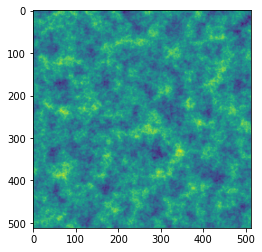

In [292]:
scale = 10
res=512

xv = np.linspace(-1, 1, res)
yv = np.linspace(-1, 1, res)
zv = np.array(np.arange(0, 1))

sampler.initNoise(frequency=0.5, octaves=10, lacunarity=2.1, gain=0.75)
n = sampler.generate_ndNoise(xv*scale, yv*scale, zv)[:,:,0]
plt.imshow(n)

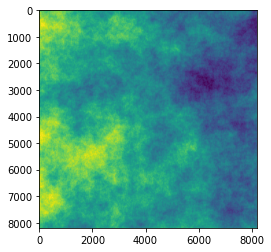

In [89]:
scale = 10
hires=res*16
xv = np.linspace(-1, 1, hires)
yv = np.linspace(-1, 1, hires)
zv = np.array(np.arange(0, 1))

n_hires = sampler.generate_ndNoise(xv*scale, yv*scale, zv)[:, :, 0]
plt.imshow(n_hires)

In [273]:
coords[0].shape

(1, 262144, 1)

### Images

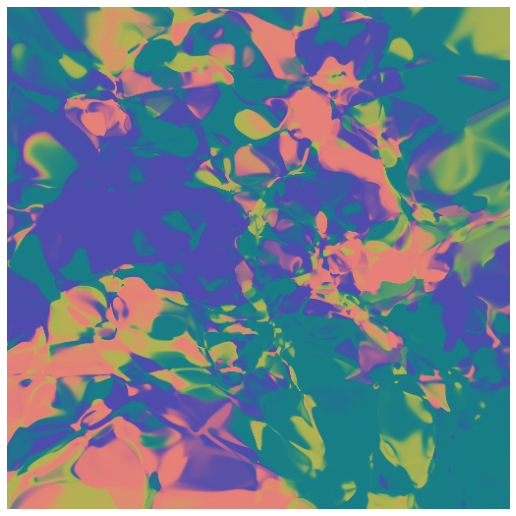

In [58]:
cppn.reinit(empty_cache=True)
gscale = 1
scale = 15
xres = 512
yres = int(512*aspectratio )
#int(512*(20/27)) # int(xres * (9/16))
zscale = 4
nscale = 0

z =  torch.randn(1, dim_z).cuda()
delta_v = torch.randn(1, dim_z).cuda() 
# delta_v = delta_v / torch.norm(delta_v)
z2 = z + 0.02*delta_v
coords = cppn._coordinates(scale*gscale,
                           xres, yres, z*zscale*gscale)

# coords[3] = torch.cos(0.5*torch.abs(coords[0]))
# coords[4] = torch.cos(0.5*torch.abs(coords[1]))
# coords[5] = coords[2]


# coords[-2] = torch.cuda.FloatTensor(np.random.random((yres, xres))).reshape(1, -1, 1)
# coords[-2] = nscale*scale*np.array(n).reshape(1, -1, 1)
# coords[0] = coords[0] * np.sin(1*coords[0])
# coords[0] = 0.3*torch.cos(*coords[0])
# coords[1] = 0.4*np.cos(2*np.abs(coords[1]))
# coords[0] = coords[0].abs()
# coords[1] = coords[1].abs()
# coords[2] = 1*np.cos(10*coords[2])
# coords[1] = coords[1] * np.sin(5*coords[1])
# coords[0] = x[:, :, 0].reshape(-1, 1)
# coords[1] = x[:, :, 1].reshape(-1, 1)
# coords[2] = x[:, :, 2].reshape(-1, 1) 
# coords[3] = coords[3].cpu().numpy() * (1 + 1/coords[2])

cppn.eval()
x = sampler.generate_img(cppn, z*zscale, scale, xres, yres, coords=coords)
sampler.imshow(x)

## Hires

100%|██████████| 10/10 [00:00<00:00, 10.36it/s]


(4050, 5120, 3)


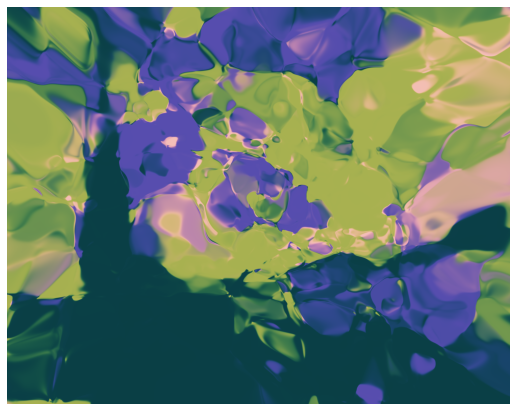

In [69]:
x_reps = 10
y_reps = 10
x_dim = 512
y_dim = int(512 * aspectratio)

scale_hires = scale*gscale
z_hires = z*zscale*gscale
coords_hires = cppn._coordinates(scale_hires, x_reps*x_dim, y_reps*y_dim, z_hires, flatten=False)
# coords_hires[0] = np.abs(coords_hires[0])
# coords_hires[0] = 2*np.cos(0.5*np.abs(coords_hires[0]))
# coords_hires[1] = 2*np.cos(0.5*np.abs(coords_hires[1]))


# crop = int((512*16 - 512*9)/2)
# coords_hires[-2] = nscale*scale*np.array(n_hires)[crop:-crop, :][np.newaxis, :]

# coords[0] = coords[0] + np.cos(coords[0]/2)
# coords[1] = coords[1] + np.sin(coords[1]/2)
# coords[3] = coords[3].cpu().numpy() * (1 + 1/coords[2])

x = sampler.generate_hires(cppn, z=z_hires, scale=scale, x_dim=x_dim, y_dim=y_dim, x_reps=x_reps, y_reps=y_reps, coords=coords_hires)
print(x.shape)
sampler.imshow(x)
  
time_str = datetime.now().strftime("%y-%m-%d-%H-%M-%S.%f")
figname = 'cppn/hi_res/' + time_str + '.png'
imageio.imwrite(figname, (x * 255).astype(np.uint8), format='png')

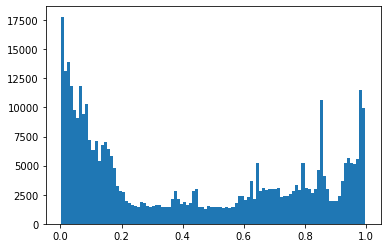

In [125]:
plt.hist(x.reshape(-1), 100);

# Train

In [65]:
import pytorch_ssim
ssim_loss = pytorch_ssim.SSIM()


MSELoss = nn.MSELoss()

In [60]:
target_file = 'cppn/target/starry.jpg'
img = Image.open(target_file)
shape = np.array(img).shape
aspectratio = shape[0] / shape[1]


In [44]:
torch.cuda.empty_cache()
del TARGET, x, out

In [61]:
def shuffle_colour(TARGET): 
    
    for i, t in enumerate(TARGET):
        rand_inds = torch.randperm(3) 
        TARGET[i] = t[:, rand_inds]
    
    return TARGET


180


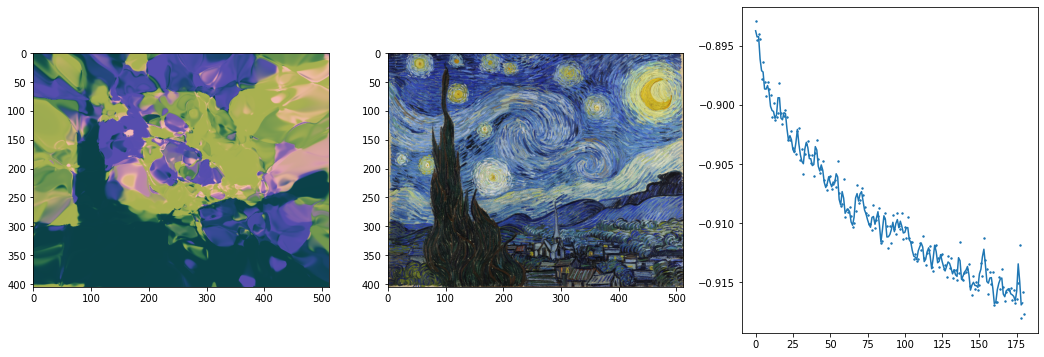

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

<Figure size 1296x432 with 0 Axes>

In [68]:
EPOCHS= 20000
XRES=512
YRES=int(XRES * aspectratio)
BATCH_SIZE=2

MASK_INDEX = 0

TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))
mask = torch.cuda.FloatTensor(TARGET[:, :, MASK_INDEX] > -1).reshape(-1)
mask = mask.unsqueeze(0).unsqueeze(-1)

TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')
TARGET = TARGET/TARGET.max()
TARGET = torch.cuda.FloatTensor(np.tile(TARGET, (BATCH_SIZE, 1, 1)))
#

# X_NULL = np.zeros((yres, xres)).reshape(1, -1, 1)
# X_NULL = nn.Parameter(torch.from_numpy(X_NULL))
# x = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=z_in, batch_size=BATCH_SIZE)
# X_NULL = np.ones((YRES, XRES)).reshape(1, -1, 1)
# X_NULL = np.tile(X_NULL, (BATCH_SIZE, 1, 1))
# X_NULL = nn.Parameter(torch.cuda.FloatTensor(X_NULL))
# x[-2] = X_NULL

SF = False
if SF:
    TARGET = shuffle_colour(TARGET)

cppn.train()

losses = []
var_z = 0.05 # variation in latent vector z across batch  

### FREEZE LAYERS
toggle_freeze = False
sparsity = 0.5

if toggle_freeze:    
    for m in cppn.rule.children():
        for l in m.children():
            if np.random.random() < sparsity:
                for p in l.parameters():
                    p.requires_grad = False
            else:
                for p in l.parameters():
                    p.requires_grad = True 

multiscale_target = False
big_factor = 0.
change_target_time = 500
keep_full = True
num_full = 1


multiscale = False
scale_range = 1

scale_in = scale
zscale = zscale
# z = torch.randn(BATCH_SIZE, dim_z).cuda()
z_in = zscale * z.repeat(BATCH_SIZE, 1)


optim = torch.optim.Adam(cppn.parameters(), lr=1e-3)
# optim = torch.optim.LBFGS(, lr=1e-3)
lambda1 = lambda epoch: 1 / (1 + epoch // 1000)
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lambda1)
need_new_grid = True


learn_z = nn.Parameter()

for epoch in range(EPOCHS):
    optim.zero_grad()
    
#     z_in = zscale * torch.randn(BATCH_SIZE, dim_z).cuda()

    
    delta_z = var_z*torch.randn(BATCH_SIZE, dim_z).cuda()
    zt = z_in + delta_z

    if need_new_grid:
        
        x = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=BATCH_SIZE)
        if multiscale_target:
            x, TARGET = multiscale_targets_apply(x, img, XRES, YRES, BATCH_SIZE, big_factor, keep_full, num_full)
        
        if multiscale and not multiscale_target: # both multiscaling can't be on at the same time
#             scale_factor = np.random.randint(1, scale_range, size=BATCH_SIZE)[:,  np.newaxis, np.newaxis]
#             scale_factor = 10**np.linspace(-scale_range/2, scale_range/2, BATCH_SIZE)[:,  np.newaxis, np.newaxis]
            scale_factor = 10**( scale_range * (np.random.uniform(size=BATCH_SIZE) - 1/2) )[:,  np.newaxis, np.newaxis]
            x[0] = x[0]*scale_factor
            x[1] = x[1]*scale_factor
            x[2] = x[2]*np.sqrt(scale_factor)
            x[-1] = x[-1]*torch.from_numpy(scale_factor).float().cuda()
            
        need_new_grid = False
    else:
        x = x[:-1]
        x.append(zt.unsqueeze(1))  # remove z layer inputs and replace with new z
        
        if multiscale:
#             scale_factor = np.random.randint(1, scale_range, size=BATCH_SIZE)[:,  np.newaxis, np.newaxis]
#             scale_factor = 10**np.linspace(-scale_range/2, scale_range/2, BATCH_SIZE)[:,  np.newaxis, np.newaxis]
#             scale_factor = 10**( scale_range * (np.random.uniform(size=BATCH_SIZE) - 1/2) )[:,  np.newaxis, np.newaxis]
            x[-1] = x[-1]*torch.from_numpy(scale_factor).float().cuda()
    
    if SF:
        TARGET = shuffle_colour(TARGET).cuda()
        
#     x[-2] = X_NULL
    
    out = cppn.forward(x, XRES, YRES)
    
    
#     out_masked = out * mask
#     TARGET = TARGET * mask
#     loss = -ssim_loss(out.reshape(BATCH_SIZE, YRES, XRES, 3) , TARGET.reshape(-1, YRES, XRES, 3))
    loss = -ssim_loss(out.mean(2).reshape(BATCH_SIZE, YRES, XRES, 1) , TARGET.mean(2).reshape(-1, YRES, XRES, 1))
#     loss = MSELoss(out.mean(2), TARGET.mean(2))
#     loss = MSELoss(out, TARGET)
#     loss = MSELoss(out.unsqueeze(1), TARGET.unsqueeze(1))
    loss.backward()
    optim.step()
    scheduler.step()
    
    losses.append(loss.item())
    

    
    if multiscale_target and epoch % change_target_time == 0:
        x = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=BATCH_SIZE)
        x, TARGET = multiscale_targets_apply(x, img, XRES, YRES, BATCH_SIZE, big_factor, keep_full, num_full)   
    
    if epoch % 30 == 0:
        alpha = 0.5
#         rand_ind = np.random.randint(len(out))
        rand_ind = 0
        nx = out[rand_ind].detach().cpu().numpy().reshape(YRES, XRES, -1)
        s_losses = alpha * np.array(losses[:-1]) + (1 - alpha) * np.array(losses[1:])

        plt.clf()
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        ax[0].imshow(nx)
#         ax[1].plot(np.log10(s_losses))
#         ax[2].scatter(np.arange(len(losses)), np.log10(losses), s=2)
        ax[2].plot(s_losses)
        ax[2].scatter(np.arange(len(losses)), losses, s=2)
        ax[1].imshow(TARGET[rand_ind].cpu().numpy().reshape(YRES, XRES, 3))
#         ax[1].set_yscale('log')
#         plt.gcf().set_size_inches((16,8))
        clear_output(wait=True)
        print(f'{epoch}')
        display(plt.gcf())
        time.sleep(0.001)
        plt.close()
        
    if epoch % 4000 == 0 and epoch != 0:
        XRES += 4
        YRES += 4 
        need_new_grid = True
        
        TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))        
        mask = torch.cuda.FloatTensor(TARGET[:, :, MASK_INDEX] > 1e-5).reshape(-1)
        mask = mask.unsqueeze(0).unsqueeze(-1)
        
        TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')
        TARGET = TARGET/TARGET.max()
#         TARGET = torch.cuda.FloatTensor(np.tile(TARGET, (BATCH_SIZE, 1, 1)))
        TARGET = torch.cuda.FloatTensor(TARGET)
        
        
        
    
    

0


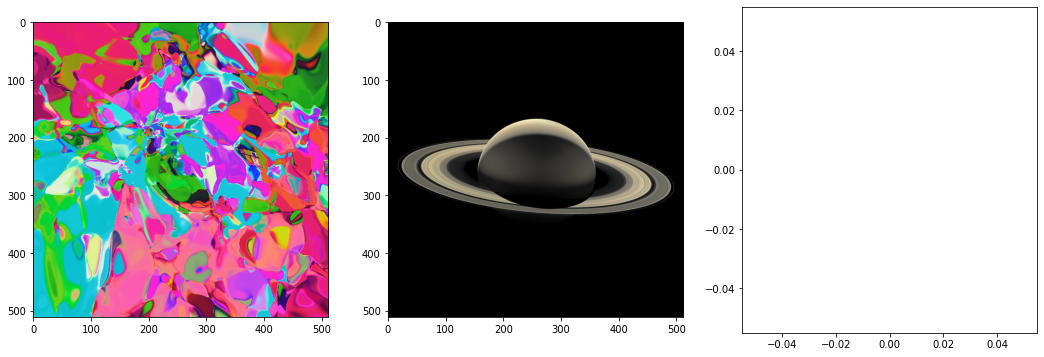

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [272]:
EPOCHS= 20000
XRES=512
YRES=int(XRES * aspectratio)
BATCH_SIZE=1

MASK_INDEX = 0

TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))
mask = torch.cuda.FloatTensor(TARGET[:, :, MASK_INDEX] > -1).reshape(-1)
mask = mask.unsqueeze(0).unsqueeze(-1)

TARGET = TARGET[:, :, :3].reshape(1, -1, 3).astype('float64')
TARGET = TARGET/TARGET.max()
TARGET = torch.cuda.FloatTensor(np.tile(TARGET, (BATCH_SIZE, 1, 1)))

losses = []
var_z = 0.00 # variation in latent vector z across batch  


scale_in = scale
zscale = zscale
# z = torch.randn(BATCH_SIZE, dim_z).cuda()
z_in = zscale * z.repeat(BATCH_SIZE, 1)

x = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=z_in, batch_size=BATCH_SIZE)
X_NULL = np.ones((YRES, XRES)).reshape(1, -1, 1)
X_NULL = np.tile(X_NULL, (BATCH_SIZE, 1, 1))
X_NULL = nn.Parameter(torch.cuda.FloatTensor(X_NULL))
x[-2] = X_NULL

optim = torch.optim.LBFGS([X_NULL])


for epoch in range(EPOCHS):
    
    def closure():
        optim.zero_grad()

        delta_z = var_z*torch.randn(BATCH_SIZE, dim_z).cuda()
        zt = z_in + delta_z

        new_x = x[:-1]
        new_x.append(zt.unsqueeze(1))  # remove z layer inputs and replace with new z

        out = cppn.forward(new_x, XRES, YRES)

        loss = -ssim_loss(out.mean(2).reshape(BATCH_SIZE, YRES, XRES, 1) , TARGET.mean(2).reshape(-1, YRES, XRES, 1))
        loss.backward()
        
        if epoch % 30 == 0:
            alpha = 0.5

            rand_ind = 0
            nx = out[rand_ind].detach().cpu().numpy().reshape(YRES, XRES, -1)
            s_losses = alpha * np.array(losses[:-1]) + (1 - alpha) * np.array(losses[1:])

            plt.clf()
            fig, ax = plt.subplots(1, 3, figsize=(18, 6))
            ax[0].imshow(nx)

            ax[2].plot(s_losses)
            ax[2].scatter(np.arange(len(losses)), losses, s=2)
            ax[1].imshow(TARGET[rand_ind].cpu().numpy().reshape(YRES, XRES, 3))

            clear_output(wait=True)
            print(f'{epoch}')
            display(plt.gcf())
            time.sleep(0.001)
            plt.close()
            
        return loss
    optim.step(closure)

    
    

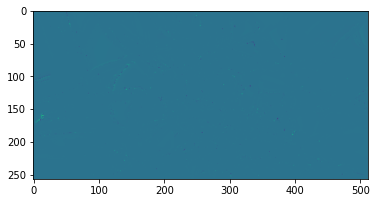

In [59]:
plt.imshow(x[-2][0].cpu().detach().numpy().reshape(YRES, XRES))

# Output weights

In [252]:
num_input_layers = 7  ## 1 for z, 3 for coordinates, 4 for extra functions. These layers have no biases
model_state_dict = cppn.state_dict()
dict_keys =list(cppn.state_dict())

# place latent layer first
dict_keys.insert(0, dict_keys[num_input_layers - 1])
dict_keys.pop(num_input_layers)


params = [model_state_dict[p].cpu().numpy() for p in dict_keys]

def tanh_activation(x):
    x = tf.nn.tanh(x)
    
    return x

def sigmoid_activation(x):
    x = tf.nn.signmoid
    
    return x 

grouped = []
pos_list = np.concatenate((np.arange(0, num_input_layers), np.arange(num_input_layers, len(params), 2)))
for pos in pos_list:
    
    if pos != len(params) - 1:
        activation_fn = tanh_activation
    else:
        activation_fn = sigmoid_activation
    
    if pos >= num_input_layers and pos < (len(params) - 1):
        bias = params[pos+1]
    else:
        bias = np.array(0)
        
    grouped.append({'weights': params[pos].transpose(), 
                   'bias': bias,
                    'activation': activation_fn
                   })


### Translate Function

In [173]:
import numpy as np

def cppn_to_glsl(layers, num_input_layers, clip=(-100, 100), fn_name="cppn_fn", mode="td", verbose=False,
                fix_aspect=True):
    '''
    Given a list of dicts defining layers of a trained CPPN (as returned by the above `eval_model` function) 
    generate GLSL code.
    
    The `mode` parameter can be one of the following:
    "shadertoy":
        Exports code compatible with the ShaderToy editor at http://shadertoy.com
    "bookofshaders":
        Exports code compatible with the Book Of Shaders editor here http://editor.thebookofshaders.com/
    "td":
        Exports code compatible with TouchDesigner: can be dropped into a "GLSL TOP"
        (see https://docs.derivative.ca/GLSL_TOP). TouchDesigner can be found at http://derivative.ca
    '''
    
    # HARD CODED CLIPPING VALUES (SINA)
    clip_min = clip[0]
    clip_max = clip[1]
    
    # the xy2rgb cppn's internal size is the output of its first layer (pre-activation)
    # so will just inspect that to figure it out
#     n_hidden = layers[0]['weights'].shape[-1]
    n_hidden = np.max([d['weights'].shape[-1] for d in grouped])
    if n_hidden%4 != 0:
        raise ValueError("Currently only support multiples of 4 for hidden layer size")
    modes = {"shadertoy", "bookofshaders", "td"}
    if mode not in modes:
        raise ValueError(f"Mode {mode} not one of the supported modes: {modes}")
        
    if mode == "bookofshaders":
        snippet =f"""
#ifdef GL_ES
precision lowp float;
#endif

uniform vec2 u_resolution;
uniform vec2 u_mouse;
uniform float u_time;

"""
    elif mode == "shadertoy":
        snippet = ""
    elif mode == "td":
        snippet = f"""
// music interaction inputs
uniform vec4 uIn0;
uniform vec4 uIn1;
uniform vec4 uIn2;
uniform vec4 uIn3;

// latent factor controls
uniform vec4 scale;
uniform vec2 Zscale;
uniform mat4 Zin;

// activation function controls


uniform vec4 h_music; // music interaction with hidden layers
uniform vec4 c_music; // music interaction with colours

uniform vec4 fParams; // amplitude of extra input functions

out vec4 fragColor;
        """
    
    snippet += f"""
#define N_HIDDEN {n_hidden}
#define M_PI 3.1415926535897932384626433832795

vec4 bufA[N_HIDDEN/4];
vec4 bufB[N_HIDDEN/4];



vec4 {fn_name}(vec2 coordinate, vec4 scale, vec2 Zscale, mat4 Zin, mat4 InSamp, vec4 fParams, vec4 in0, vec4 in1, vec4 in2, vec4 in3, vec4 h_music, vec4 c_music) {{
    coordinate.xy = scale[0]*coordinate.xy;
    float r = sqrt(coordinate.x*coordinate.x + coordinate.y*coordinate.y);
    mat4 Zvec = Zscale.x * mat4(in0, in1, in2, in3) + Zscale.y * Zin;
    vec4 tmp;
    // bufB[0] = vec4(coordinate.x, coordinate.y, r, 0.);
    
"""
    def vec(a):
        '''Take a Python array of length four (or less) and output code for
        a GLSL vec4, possibly zero-padded at the end'''
        if len(a) == 4:
            return f"vec4({','.join(str(x) for x in a)})"
        else:
            assert len(a) < 4 , "Length must less than 4"
            return vec(np.concatenate([a, [0.]*(4-len(a))]))
    
    def mat(a):
        '''Tak a numpy matrix of 4 rows and 4 or fewer columns, and output GLSL code
        for a mat4, possibly with zeros padded in the final columns'''
        if a.shape[0] < 4:
            m2 = np.vstack([a, [[0.,0.,0.,0.]] * (4 - a.shape[0])])
            return mat(m2)
        assert a.shape[0] == 4, f"Expected a of shape (4,n<=4). Got: {a.shape}."
        return f"mat4({','.join(vec(row) for row in a)})"
    
    for layer_i, layer_dict in enumerate(layers):
        weight = layer_dict['weights']
        bias = layer_dict['bias']
        activation = layer_dict['activation']
        
        from_size, to_size = weight.shape
        if verbose:
            print(f"Processing layer {layer_i}. from_size={from_size}, to_size={to_size}")
        
        ## Set inputs 
        if layer_i < num_input_layers:
            if layer_i == 0: snippet += f"\n// Latent Vector Inputs \n"
            elif layer_i == 1:
                snippet += f"\n// INPUT1 \n"
                snippet += f"tmp = vec4(coordinate.x, 0., 0., 0.);\n"
            elif layer_i == 2:
                snippet += f"\n// INPUT2 \n"
                snippet += f"tmp = vec4(coordinate.y, 0., 0., 0.);\n"
            elif layer_i == 3:
                snippet += f"\n// INPUT3 \n"
                snippet += f"tmp = vec4(r, 0., 0., 0.);\n"
            elif layer_i == 4:
                snippet += f"\n// INPUT4 \n"
                snippet += f"tmp = InSamp[0] * fParams[0];\n"
            elif layer_i == 5:
                snippet += f"\n// INPUT5 \n"
                snippet += f"tmp = InSamp[1] * fParams[1];\n"
            elif layer_i == 6:
                snippet += f"\n// INPUT6 \n"
                snippet += f"tmp = InSamp[2] * fParams[2];\n"
            elif layer_i == 7:
                snippet += f"\n// INPUT7 \n"
                snippet += f"tmp = InSamp[3] * fParams[3];\n"
                snippet += f"tmp = vec4(cos(coordinate.x * scale[3]) + sin(coordinate.y * scale[3] + M_PI/2), 0., 0., 0.) * fParams[3];\n"    
        
        # First, compute the transformation from the last layer into bufA
        for to_index in range(max(1,to_size//4)):
            #Again, the max(1) is important here, because to_size is 3 for the last layer!
            if verbose: print(f"  generating output {to_index} into bufA")
            
            ##### DEALING WITH INPUT LAYERS ######
            if layer_i < num_input_layers:
                # I have multiple input layers and they don't have biases
                # Furthermore, each input goes through its own layer before being added up
                snippet += f"\nbufA[{to_index}] = vec4(0., 0., 0., 0.)"
                if layer_i == 0:
                # this is for the latent vector Z which is of size 16 (mat4)                  
                    for from_index in range(max(1, from_size//4)):
                        snippet += f" + {mat(weight[from_index*4:from_index*4+4, to_index*4:to_index*4+4])} * Zvec[{from_index}]"
                else:                        
                    for from_index in range(max(1, from_size//4)):
                        snippet += f" + {mat(weight[from_index*4:from_index*4+4, to_index*4:to_index*4+4])} * tmp"    
    #                     if verbose: print(f"        {weight[from_index*4:from_index*4+4, to_index*4:to_index*4+4].shape}")
                        
            #################
            
            else:    
                if not bias.shape:
                    snippet += f"\nbufA[{to_index}] = vec4(0., 0., 0., 0.)"
                else:
                    snippet += f"\nbufA[{to_index}] = {vec(bias[to_index*4:to_index*4+4])}"
                for from_index in range(from_size//4):
                    snippet += f" + {mat(weight[from_index*4:from_index*4+4, to_index*4:to_index*4+4])}  * bufB[{from_index}]"
                
            snippet += f";\n"
            
        if to_size != 3:
            if verbose: print("  Doing the activation into bufB ")
            if layer_i >= num_input_layers:
                snippet += f"\n// Activation on neurons in layer {layer_i - num_input_layers + 1}. \n"
            elif layer_i == (num_input_layers - 1):
                snippet += f"\n// Activation on inputs. \n"
            m_index = 0
            for to_index in range(to_size//4):
                
                if activation == tanh_activation:
                    # first sum input layers, then apply activation function
                    if layer_i < (num_input_layers - 1):
                        snippet += f"bufB[{to_index}] = bufB[{to_index}] + bufA[{to_index}];\n"
                    elif layer_i == (num_input_layers - 1):
                        if m_index > 3:
                            m_index = 0
                        snippet += f"tmp = (bufB[{to_index}] + bufA[{to_index}]) * h_music[{m_index}];\n"
#                         snippet += f"tmp = tmp*tmp*tmp;\n"
                        snippet += f"bufB[{to_index}] = tanh(tmp);\n"
                        m_index += 1
                    else:
                        snippet += f"tmp = bufA[{to_index}];\n"
                        snippet += f"bufB[{to_index}] = tanh(tmp);\n"
                    
                elif activation == sigmoid_activation:
                    snippet += f"bufB[{to_index}] = 1./(1. + exp2(-bufA[{to_index}] * c_music));\n"
                    

                    #return (x-0.40)/0.58
                    # return tf.concat([(x-0.40)/0.58, (xx-0.40)/0.58], -1)
                else:
                    raise ValueError(f"Unknown activation: {activation.__name__}")
        else:
            if verbose:
                print("  Sigmoiding the last layer")
            # We just do a sigmoid at the last layer.
            sigmoider = lambda s: f"1. / (1. + exp(-{s}))"
            snippet += f"return vec4(({sigmoider('bufA[0] * c_music')}).xyz, 1.0);\n"
    snippet += "}\n"
    if mode=="bookofshaders":
        snippet += f"""
void main() {{
    vec2 st = gl_FragCoord.xy/u_resolution.xy;
"""
        if fix_aspect:
            snippet += f"""
    st.x *= u_resolution.x/u_resolution.y;
    st.x -= ((u_resolution.x / u_resolution.y) - 1.) /2.;
"""
        snippet += f"""
    st = vec2(1., -1.) * 2. * (st - vec2(0.5, 0.5));

    gl_FragColor = {fn_name}(st, sin(u_time), sin(2.*u_time), sin(3.*u_time), sin(4.*u_time));
}}
"""
    elif mode == "shadertoy":
        snippet += f"""
void mainImage( out vec4 fragColor, in vec2 fragCoord ) {{
    // Normalized pixel coordinates (from 0 to 1)
    vec2 uv = fragCoord/iResolution.xy;
    vec2 mouseNorm = (iMouse.xy / iResolution.xy) - vec2(0.5, 0.5);

"""
        if fix_aspect:
            snippet += f"""
    uv.x *= iResolution.x / iResolution.y;
    uv.x -= ((iResolution.x / iResolution.y) - 1.) /2.;
"""
        snippet += f"""

    // Shifted to the form expected by the CPPN
    uv = vec2(1., -1.) * 2. * (uv - vec2(0.5, 0.5));
    // Output to screen
    fragColor = {fn_name}(uv, sin(iTime), sin(2.*iTime), sin(3.*iTime), sin(4.*iTime));
}}
        """
    elif mode == "td":
        snippet += f"""
void main() {{

    // derive aspect from inputs
    vec2 aspect = uTD2DInfos[0].res.zw / uTD2DInfos[0].res.w ; 
    // Normalized pixel coordinates (from 0 to 1)
    vec2 uv = vUV.xy;

    // sample texture
    mat4 InSamp = mat4(texture(sTD2DInputs[0], uv), texture(sTD2DInputs[1], uv), texture(sTD2DInputs[2], uv), vec4(0., 0., 0., 0.));
    
    // correct for aspect
    // uv = uv * aspect;
    
    // Shifted to the form expected by the CPPN
    uv.xy = vec2(1280./720., 720./720.) * vec2(1., -1.) * 2. * (uv.xy - vec2(0.5, 0.5));
    
    // Output to screen
    fragColor = TDOutputSwizzle({fn_name}(uv.xy, scale, Zscale, Zin, InSamp, fParams, uIn0, uIn1, uIn2, uIn3, h_music, c_music));
}}
        """
    return snippet

### Translate

In [253]:
print(cppn_to_glsl(grouped, num_input_layers, mode="td", verbose=False, fix_aspect=True), file=open('td_glsl_log.txt', 'w'))

# Debug code snippets

In [74]:
x = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=3000)
# x, TARGET = multiscale_targets_apply(x, img, XRES, YRES, BATCH_SIZE=BATCH_SIZE, big_factor=0.5, keep_full=True, num_full=1)
# img2 = cppn._coordinates(scale_in, xres=10*XRES, yres=10*YRES, z=zt, batch_size=1, flatten=False)[:3]
# img2= (img2[0][0] + img2[1][0] + img2[2][0])
a, S, T = multiscale_targets(img, x, (YRES, XRES), 1000, big_factor=0)

min_x_old = x[0].min(1)[:, 0]
min_x_scaled = min_x_old*S[:, 1]
translation_x = T[:, 1]*np.abs(min_x_old) - min_x_scaled
X = x[0] * S[:, 1][:, None, None] + translation_x[:, None, None]

min_y_old = x[1].min(1)[:, 0]
min_y_scaled = min_y_old*S[:, 0]
translation_y = T[:, 0]*np.abs(min_y_old) - min_y_scaled
Y = x[1] * S[:, 0][:, None, None] + translation_y[:, None, None]

R = np.sqrt(X**2 +  Y**2)

# X, Y, R = x[0], x[1], x[2]

z.shape[0] != batch_size. Doing nothing.


ValueError: operands could not be broadcast together with shapes (3000,) (1000,) 

In [ ]:
full = cppn._coordinates(scale_in, xres=XRES, yres=YRES, z=zt, batch_size=1)
x_dat = np.concatenate([full[0], X]).reshape(-1)
y_dat = np.concatenate([full[1], Y]).reshape(-1)
plt.hist2d(x_dat, y_dat, 200);

793


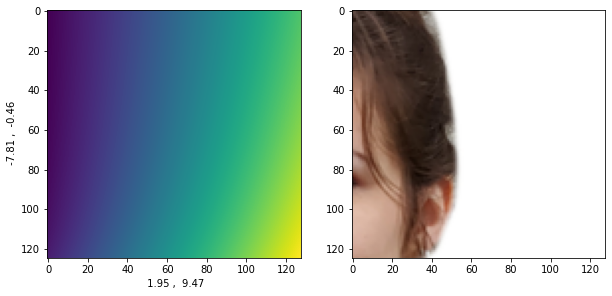

In [341]:
# i = np.random.randint(len(a))
# i = 0
b = [X, Y, R]
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(b[0][i].reshape(YRES, XRES) + b[1][i].reshape(YRES, XRES) + b[2][i].reshape(YRES, XRES))
ax[0].set_xlabel(f' {b[0][i].min():.2f} ,  {b[0][i].max():.2f}')
ax[0].set_ylabel(f' {b[1][i].min():.2f} ,  {b[1][i].max():.2f}')

ax[1].imshow(a[i])
print(i)

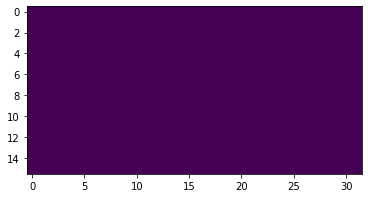

In [454]:
TARGET = np.array(img.resize((XRES, YRES), Image.ANTIALIAS))
mask = TARGET[:, :, MASK_INDEX] > -1
plt.imshow(mask[0].cpu().numpy().reshape(YRES,XRES))

In [421]:
cppn.rule

Rule(
  (in_l): ModuleList(
    (0): Linear(in_features=1, out_features=128, bias=False)
    (1): Linear(in_features=1, out_features=128, bias=False)
    (2): Linear(in_features=1, out_features=128, bias=False)
    (3): Linear(in_features=1, out_features=128, bias=False)
    (4): Linear(in_features=16, out_features=128, bias=False)
  )
  (seq): ModuleList(
    (0): Tanh()
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Tanh()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): Tanh()
    (5): Linear(in_features=128, out_features=16, bias=True)
    (6): Tanh()
    (7): Linear(in_features=16, out_features=3, bias=True)
    (8): Sigmoid()
  )
)